In [1]:
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("data.csv")
df = df.drop(columns=["id", "Unnamed: 32"])

df.eq(0).sum()
mean_con = df[df['concavity_mean'] != 0]['concavity_mean'].mean()
mean_con_m = df[df['concave points_mean'] != 0]['concave points_mean'].mean()
mean_con_se = df[df['concavity_se'] != 0]['concavity_se'].mean()
mean_con_m_se = df[df['concave points_se'] != 0]['concave points_se'].mean()
mean_con_w = df[df['concavity_worst'] != 0]['concavity_worst'].mean()
mean_con_m_w = df[df['concave points_worst'] != 0]['concave points_worst'].mean()

df['concavity_mean'].replace(0, mean_con, inplace=True)
df['concave points_mean'].replace(0, mean_con_m, inplace=True)
df['concavity_se'].replace(0, mean_con_se, inplace=True)
df['concave points_se'].replace(0, mean_con_m_se, inplace=True)
df['concavity_worst'].replace(0, mean_con_w, inplace=True)
df['concave points_worst'].replace(0, mean_con_m_w, inplace=True)

In [3]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.090876,0.050063,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.278553,0.117286,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.078553,0.038074,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.204423,0.063349,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000692,0.001852,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.001845,0.008772,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.031360,0.021070,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.124200,0.066960,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.066640,0.037000,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.241300,0.104700,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [5]:
# Drop rows with null values
df = df.dropna()

In [6]:
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

In [7]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2)

In [10]:
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [11]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]})

In [12]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [13]:
# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50)


In [14]:
model = RandomForestClassifier(best_model)

In [15]:
kfold = KFold(n_splits=10)
scores = cross_val_score(best_model, X_reduced, y, cv=kfold)

In [16]:
print(f"Mean score: {scores.mean():.3f}")
print(f"Standard deviation: {scores.std():.3f}")

Mean score: 0.940
Standard deviation: 0.039


In [17]:
# Calculate the standard error of the mean (SEM)
sem = scores.std() / np.sqrt(len(scores))

# Calculate the 95% confidence interval
confidence_interval = norm.interval(0.95, loc=scores.mean(), scale=sem)

print(f"Confidence interval: {confidence_interval}")

Confidence interval: (0.9159397123413177, 0.9647620420446473)


<function matplotlib.pyplot.show(close=None, block=None)>

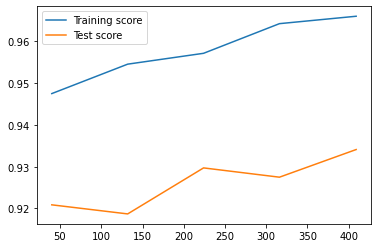

In [18]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=kfold)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Test score")
plt.legend()
plt.show

In [19]:
y_pred = best_model.predict(X_test)

In [20]:
# Generate the confusion matrix and classification report
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(confusion_mat)
print(classification_rep)

[[71  3]
 [ 4 36]]
              precision    recall  f1-score   support

           B       0.95      0.96      0.95        74
           M       0.92      0.90      0.91        40

    accuracy                           0.94       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



In [21]:
print("Accuracy:", best_model.score(X_test, y_test))
print("Precision:", classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"])
print("Recall:", classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"])

Accuracy: 0.9385964912280702
Precision: 0.9383895636527214
Recall: 0.9385964912280702
